# Sentiment Analysis using an Artificial Neural Network

Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import models
from keras.layers import Dense
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)

Loading the Dataset

In [2]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IMDB Dataset.csv')

In [3]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Encoding the Reviews, given in the form of 'positive' and 'negative' as 1 for positive and 0 for negative.

In [4]:
lb = LabelEncoder()
dataset['sentiment'] = lb.fit_transform(dataset['sentiment'])

Initializing the NLTK Objects

In [6]:
tokenizer = RegexpTokenizer(r'\w+')
en_stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

Defining a function to Tokenize, Stem and Clean the texts

In [7]:
def getStemmedReview(reviews):
  review = reviews.lower()
  review = review.replace('<br /><br />', "")

  tokens = tokenizer.tokenize(review)
  new_tokens = [token for token in tokens if token not in en_stopwords]
  stemmed_tokens = [ps.stem(token) for token in new_tokens]

  clean_review = ' '.join(stemmed_tokens)

  return clean_review

Calling the ```getStemmedReview()``` function on the entire dataset

In [8]:
Corpus = []
for i in range(dataset.shape[0]):
  Corpus.append(getStemmedReview(dataset['review'][i]))

Vectorizing the reviews

In [9]:
cv = CountVectorizer(max_features = 10000)
x = cv.fit_transform(Corpus).toarray()

Creating a variable ```y```

In [10]:
y = dataset['sentiment'].values

Splitting the dataset for training on the base model i.e. Naive Bayes Model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

Training the model on the base model

In [12]:
classifer = GaussianNB()
classifer.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Finding the accuracy of the base model

In [13]:
y_pred = classifer.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[4328  707]
 [2304 2661]]
0.6989


Now, the accuracy of the base model without hyperparameter tuning or any changes is 69.89% ~ 70%. Hence, we have to create a model which can outperform this.

Initializing a 3 Layer Artificial Neural Network with 2 Hidden Layers. The Activation Function of the Hidden Layers will be the ReLU function, while since this binary classification, the activation function of the output layer is kept as the sigmoid function.

In [15]:
model = models.Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Using the RMSProp Optimizer to add emphasis to horizontal momentum, and take larger steps to convergence. We use the Binary Cross Entropy Loss Function (Same as in Logistic Regression).

In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Here is the summary of the model.

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


Creating a validation set out of the existing training set

In [20]:
X_train_NN, X_val, y_train_NN, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = 5)

Fitting the model.

In [ ]:
hist = model.fit(X_train_NN, y_train_NN, epochs = 20, batch_size = 512, validation_data = (X_val, y_val))

In [22]:
h = hist.history 

We initialised the model with 20 epochs, which gave us the following graphs. 

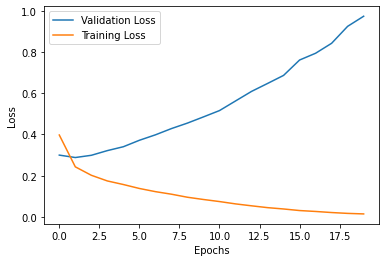

In [25]:
plt.plot(h['val_loss'], label = 'Validation Loss')
plt.plot(h['loss'], label = 'Training Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

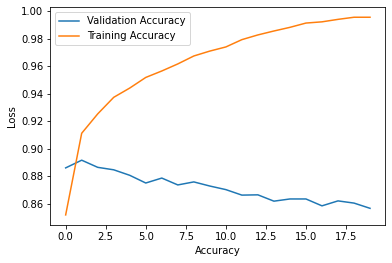

In [31]:
plt.plot(h['val_accuracy'], label = 'Validation Accuracy')
plt.plot(h['accuracy'], label = 'Training Accuracy')
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.show()

We can clearly observe that the accuracy for the validation set is the highest at the time of the 2nd epoch, hence we retrain the model from scratch. This time we keep number of epochs to 2.

In [21]:
hist = model.fit(X_train_NN, y_train_NN, epochs = 2, batch_size = 512, validation_data = (X_val, y_val))

Train on 35000 samples, validate on 5000 samples
Epoch 1/2
35000/35000 [==============================] - 3s 74us/step - loss: 0.3975 - accuracy: 0.8518 - val_loss: 0.3000 - val_accuracy: 0.8860
Epoch 2/2
35000/35000 [==============================] - 2s 66us/step - loss: 0.2432 - accuracy: 0.9112 - val_loss: 0.2883 - val_accuracy: 0.8916


Now, we can observe a positive change in the graphs.

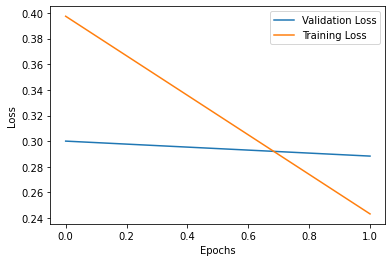

In [23]:
plt.plot(h['val_loss'], label = 'Validation Loss')
plt.plot(h['loss'], label = 'Training Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

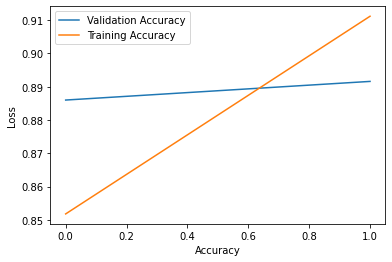

In [24]:
plt.plot(h['val_accuracy'], label = 'Validation Accuracy')
plt.plot(h['accuracy'], label = 'Training Accuracy')
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.show()

Evaluating the model on the test set. It gives an accuracy of 88.66%.

In [25]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 54us/step


[0.2909127568244934, 0.8866000175476074]

In [28]:
results = model.predict(X_test)
for i,j in enumerate(results):
  if j >= 0.5:
    results[i] = 1
  else:
    results[i] = 0

Confusion Matrix for the test set for further calculations

In [30]:
cm = confusion_matrix(y_test, results)
print(cm)

[[4318  717]
 [ 417 4548]]


Saving the model 

In [31]:
model.save('/content/drive/My Drive/Colab Notebooks/model.h5')